# Imports, leitura de arquivos e primeiros contatos com os dados

Todas as respostas e explicações que achei necessárias estão em suas respectivas seções.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dython.nominal import associations
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args
from lightgbm import LGBMClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
FILE_PATH = os.path.abspath("__file__")
PROJECT_PATH = os.path.dirname(FILE_PATH)
DATA_PATH = os.path.join(PROJECT_PATH, 'data')

In [4]:
df_train = pd.read_csv(os.path.join(DATA_PATH,'wage_train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH,'wage_test.csv'))

In [5]:
df_train.head()

,Unnamed: 0,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,yearly_wage
0,0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


<AxesSubplot:>

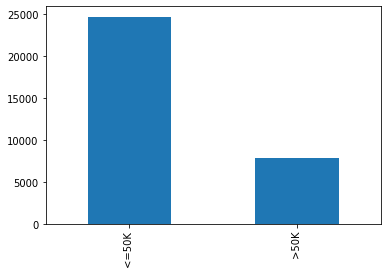

In [6]:
df_train.yearly_wage.value_counts().plot(kind='bar')

Apesar de estarmos prevendo um valor (o salário de alguém) o problema trata-se de um problema de classificação, pois estamos lidando com dois valores discretos (>50k ou <=50k)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      32560 non-null  int64 
 1   age             32560 non-null  int64 
 2   workclass       32560 non-null  object
 3   fnlwgt          32560 non-null  int64 
 4   education       32560 non-null  object
 5   education_num   32560 non-null  int64 
 6   marital_status  32560 non-null  object
 7   occupation      32560 non-null  object
 8   relationship    32560 non-null  object
 9   race            32560 non-null  object
 10  sex             32560 non-null  object
 11  capital_gain    32560 non-null  int64 
 12  capital_loss    32560 non-null  int64 
 13  hours_per_week  32560 non-null  int64 
 14  native_country  32560 non-null  object
 15  yearly_wage     32560 non-null  object
dtypes: int64(7), object(9)
memory usage: 4.0+ MB


In [8]:
num_features = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
cat_features = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 
                'native_country', 'yearly_wage']

Durante o desenvolvimento do código, percebi que havia um espaço antes de alguns dados. Portanto, vou fazer uma espécie de pré-processamento e remover esses espaços para me facilitar.

In [9]:
df_train.sex.unique()

array([' Male', ' Female'], dtype=object)

In [10]:
df_train[cat_features] = df_train[cat_features].apply(lambda x: x.str.strip().str.lower())
cat_features.remove('yearly_wage')
df_test[cat_features] = df_test[cat_features].apply(lambda x: x.str.strip().str.lower())
df_train.sex.unique()

array(['male', 'female'], dtype=object)

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16280 entries, 0 to 16279
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      16280 non-null  int64 
 1   age             16280 non-null  int64 
 2   workclass       16280 non-null  object
 3   fnlwgt          16280 non-null  int64 
 4   education       16280 non-null  object
 5   education_num   16280 non-null  int64 
 6   marital_status  16280 non-null  object
 7   occupation      16280 non-null  object
 8   relationship    16280 non-null  object
 9   race            16280 non-null  object
 10  sex             16280 non-null  object
 11  capital_gain    16280 non-null  int64 
 12  capital_loss    16280 non-null  int64 
 13  hours_per_week  16280 non-null  int64 
 14  native_country  16280 non-null  object
dtypes: int64(7), object(8)
memory usage: 1.9+ MB


É possível verificar que:
* Em ambos datasets (treino e teste) as variáveis de mesmo nome possuem tipos iguais
* Não há valores nulos nos datasets, porém há valores "?" que serão tratados à frente.

In [12]:
df_train.describe()

,Unnamed: 0,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32560.000000,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,16279.500000,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,9399.406719,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,0.000000,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,8139.750000,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,16279.500000,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,24419.250000,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,32559.000000,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Por aqui já pude perceber que capital_gain e capital_loss eram variaveis esparsas (com muitos zeros), pois os quartis (min-25, 25-50, 50-75 e 76-max) estão marcados por zeros (pelo menos os prieiros 75% dos dados).

In [13]:
df_train.education_num.value_counts()

9     10501
10     7291
13     5354
14     1723
11     1382
7      1175
12     1067
6       933
4       646
15      576
5       514
8       433
16      413
3       333
2       168
1        51
Name: education_num, dtype: int64

In [14]:
df_train.education.value_counts()

hs-grad         10501
some-college     7291
bachelors        5354
masters          1723
assoc-voc        1382
11th             1175
assoc-acdm       1067
10th              933
7th-8th           646
prof-school       576
9th               514
12th              433
doctorate         413
5th-6th           333
1st-4th           168
preschool          51
Name: education, dtype: int64

Aqui é possível observar que education e education_num descrevem a mesma coisa, portanto excluirei a coluna education no final.

In [15]:
df_train.capital_loss.value_counts()

0       31041
1902      202
1977      168
1887      159
1848       51
        ...  
2080        1
1539        1
1844        1
2489        1
1411        1
Name: capital_loss, Length: 92, dtype: int64

Aqui confirmei a hipótese de cima.

# EDA e Insights

Seção Dedicada a Análise Exploratória de Dados. Aqui plotarei alguns gráficos, tirarei alguns insights e responderei alguas dúvidas.

<AxesSubplot:title={'center':'Salario por escolaridade'}, xlabel='Escolaridade', ylabel='Qtd de pessoas'>

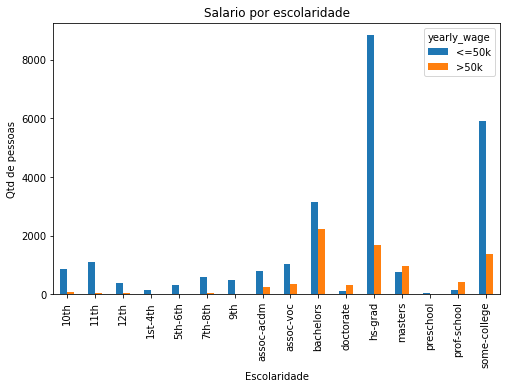

In [16]:
df_train.groupby(['education', 'yearly_wage']).size().unstack().plot(kind='bar', figsize=(8,5),
                                                                     title='Salario por escolaridade',
                                                                     xlabel='Escolaridade', ylabel='Qtd de pessoas')

Aqui vemos que a escolaridade é diretamente proporcional ao salário, pois bachareis, mestres e doutores são os que mais recebem acima de 50k.

<AxesSubplot:title={'center':'Salario por idade'}, xlabel='Idade', ylabel='Qtd de pessoas'>

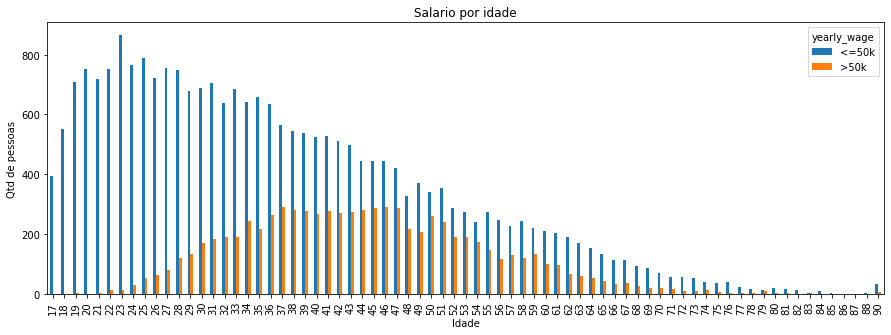

In [17]:
df_train.groupby(['age', 'yearly_wage']).size().unstack().plot(kind='bar', figsize=(15,5),
                                                                     title='Salario por idade',
                                                                     xlabel='Idade', ylabel='Qtd de pessoas')

Esse gráfico nos mostra a relação que a idade possui com o salário anual das pessoas. É possível ver que há um ápice na faixa dos 40-50 anos, o que faz sentido, pois é nessa idade que muitos atingem o nível senior.

## Mulheres ganham menos?

É sabido estatisticamente que mulheres ganham menos que homens até mesmo ocupando o mesmo cargo. Mas isso só vale quando o salário é um valor numérico, pois a precisão do cálculo é muito maior. A questão a ser respondida aqui é: isso vale quando o salário e representado de forma discreta?

In [18]:
df_train.sex.value_counts()

male      21789
female    10771
Name: sex, dtype: int64

Acima apenas quis assegurar que não havia um outro gênero.

<AxesSubplot:title={'center':'Diferença salarial entre sexos'}, xlabel='Sexo', ylabel='Qtd de pessoas'>

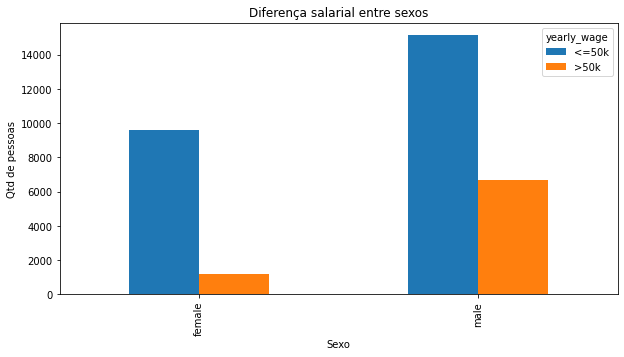

In [19]:
pd.crosstab(df_train['sex'],df_train['yearly_wage']).plot(kind='bar', figsize=(10,5), 
                                                          title='Diferença salarial entre sexos',
                                                          xlabel='Sexo', ylabel='Qtd de pessoas')

Esse gráfico nos permite ver que a porcentagem de mulheres que ganham mais de 50k é consideravelmente menor que a porcentagem de homens que ganham mais de 50k. Entretanto ele não considera o emprego do indivíduo por sexo.

<AxesSubplot:title={'center':'Diferença salarial entre sexos com mesmo emprego'}, xlabel='Ocupação por sexo', ylabel='Qtd de pessoas'>

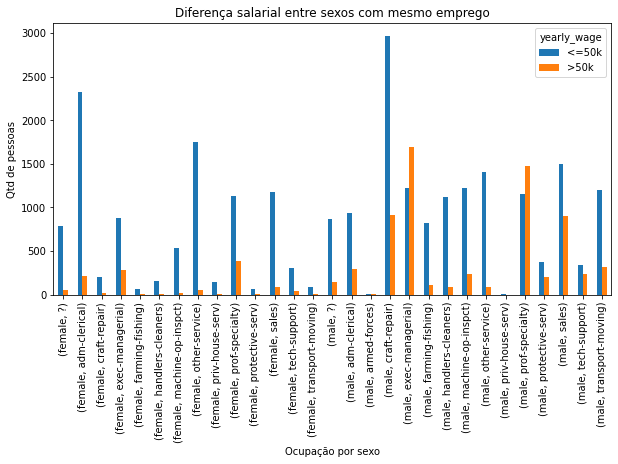

In [20]:
df_train.groupby(['sex','occupation','yearly_wage']).size().unstack().plot(kind='bar', figsize=(10,5), 
                                                                           title='Diferença salarial entre sexos com mesmo emprego',
                                                                           xlabel='Ocupação por sexo', ylabel='Qtd de pessoas')

Já esse gráfico nos permite ver a diferença salarial entre homens e mulheres que possuem o mesmo emprego. Claramente homens que ocupam a mesma vaga que mulheres ganham mais.

<AxesSubplot:title={'center':'Escolaridade dos sexos'}, xlabel='Sexo', ylabel='Qtd de pessoas'>

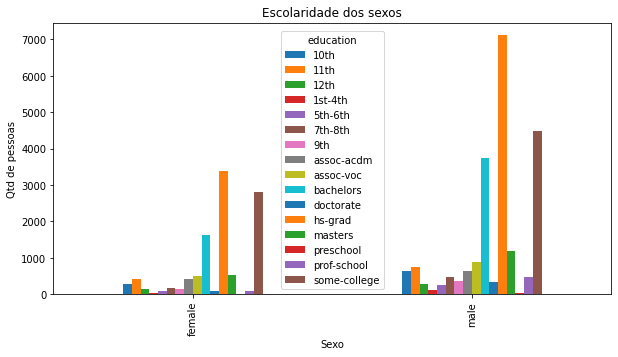

In [21]:
pd.crosstab(df_train['sex'],df_train['education']).plot(kind='bar', figsize=(10,5), 
                                                          title='Escolaridade dos sexos',
                                                          xlabel='Sexo', ylabel='Qtd de pessoas')

Aqui é possível ver que não há uma diferença impactante entre a escolaridade de homens e mulheres. Portanto não serve como justificativa para a diferença salarial.

<AxesSubplot:title={'center':'Diferença salarial (global) entre mulheres por estado civil'}, xlabel='Estado civil', ylabel='Número de mulheres'>

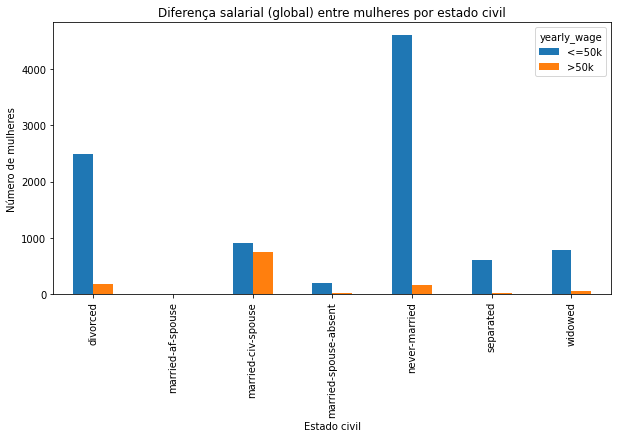

In [22]:
pd.crosstab(df_train[df_train['sex']=='female']['marital_status'],df_train[df_train['sex']=='female']['yearly_wage']).plot(kind='bar', figsize=(10,5), 
                                                          title='Diferença salarial (global) entre mulheres por estado civil',
                                                          xlabel='Estado civil', ylabel='Número de mulheres')

Um dado interessante de se observar é que mulheres casadas (que moram com os maridos, married-civ-spouse) tendem a ganhar mais proporcionalmente que as demais mulheres.

# Dados envolvendo diferentes raças

<AxesSubplot:title={'center':'Diferença salarial entre raças'}, xlabel='Raça', ylabel='Qtd de pessoas'>

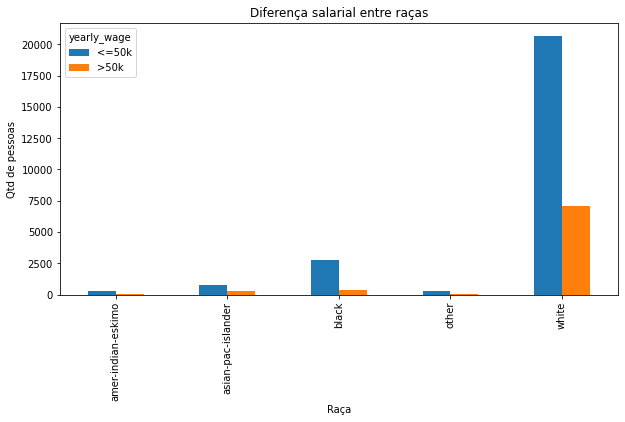

In [23]:
pd.crosstab(df_train['race'],df_train['yearly_wage']).plot(kind='bar', figsize=(10,5), 
                                                          title='Diferença salarial entre raças',
                                                          xlabel='Raça', ylabel='Qtd de pessoas')

<AxesSubplot:xlabel='yearly_wage', ylabel='proporção'>

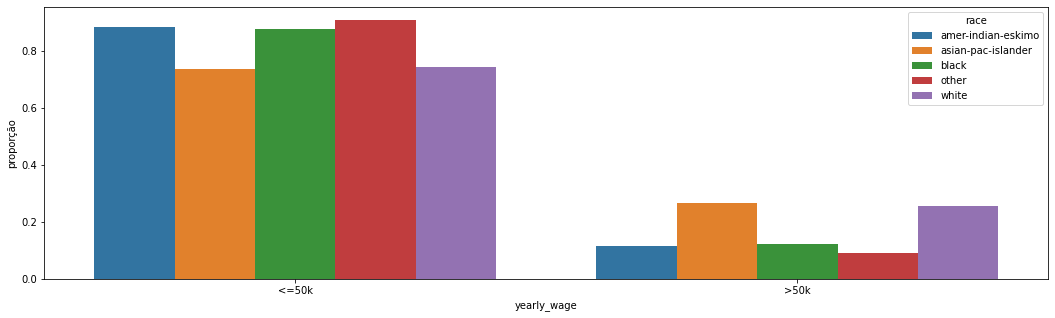

In [24]:
x, y, hue = "yearly_wage", "proporção", "race"
plt.figure(figsize=(18,5))

(df_train[x]
 .groupby(df_train[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

Como esperado, asiaticos e brancos tendem a ganhar mais que negros, nativos e outros (latinos, talvez?)

In [25]:
df_train.race.unique()

array(['white', 'black', 'asian-pac-islander', 'amer-indian-eskimo',
       'other'], dtype=object)

<AxesSubplot:xlabel='education', ylabel='proporção'>

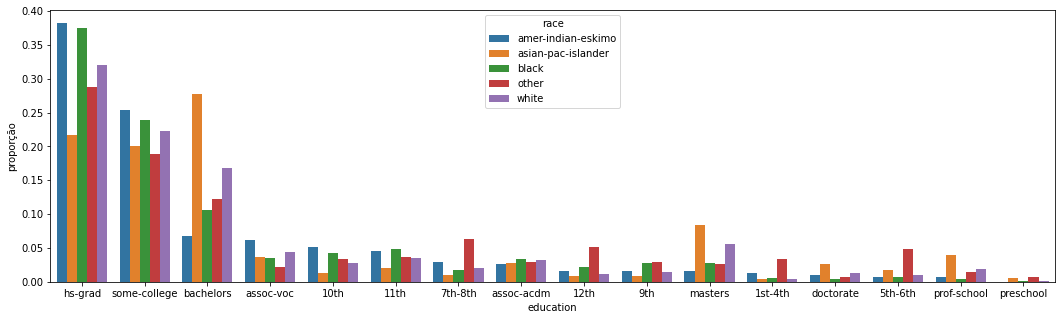

In [26]:
x, y, hue = "education", "proporção", "race"
plt.figure(figsize=(18,5))

(df_train[x]
 .groupby(df_train[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

Aqui vemos uma superioridade percentual de asiáticos com maior grau de escolaridade, seguido por brancos, outros, negros e nativos.

# Explorando mais os dados

Seção dedicada a explorar as variáveis não exploradas antes, buscar outliers (verificação de mediana em boxplots), missing values, verificar correlações, etc.

In [27]:
len(df_train.native_country.unique())

42

<AxesSubplot:>

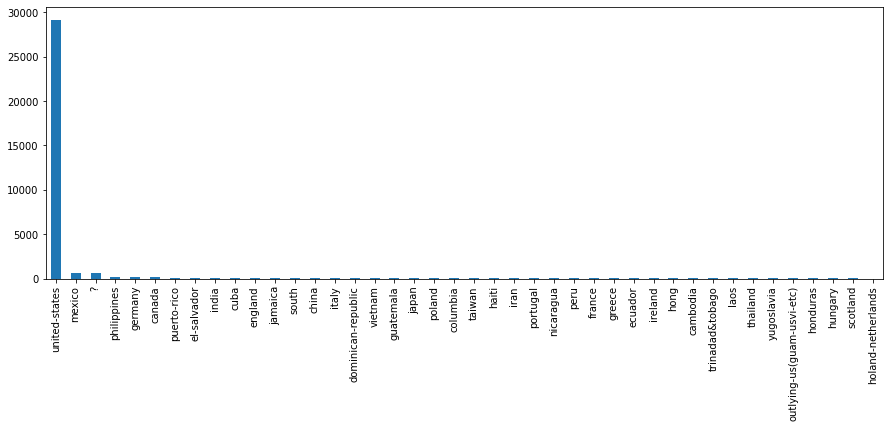

In [28]:
df_train.native_country.value_counts().plot(kind='bar', figsize=(15,5))

Os dados dos países estão extremamente desbalanceados. Em condições normais, seria uma feature que talvez valesse a pena trabalhar mais nela para equilibrar esses dados, seja buscando de fontes externas ou usando técnicas como SMOTE, mas aqui talvez eu apenas a exclua, afinal ela possui várias categorias (tornando a opção do one-hot encoding pouco interessante) e não parece influenciar muito nos dados.

<AxesSubplot:title={'center':'Diferença salarial entre categorias de emprego'}, xlabel='Categorias de eprego', ylabel='Qtd de pessoas'>

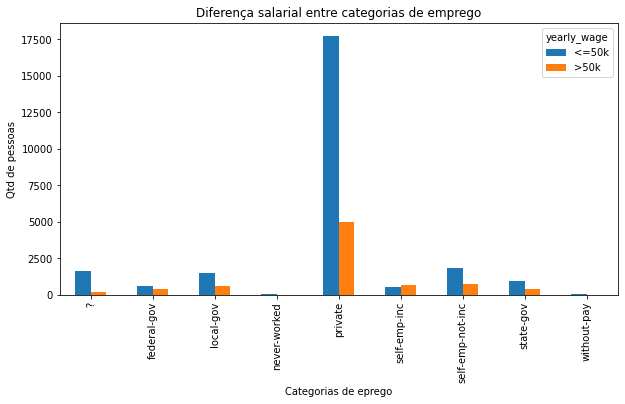

In [29]:
pd.crosstab(df_train['workclass'],df_train['yearly_wage']).plot(kind='bar', figsize=(10,5), 
                                                          title='Diferença salarial entre categorias de emprego',
                                                          xlabel='Categorias de eprego', ylabel='Qtd de pessoas')

Aqui vemos que a única classe de empregos que a maioria ganha mais de 50k são os que trbalham para si (empreendedores).

<AxesSubplot:xlabel='education', ylabel='proporção'>

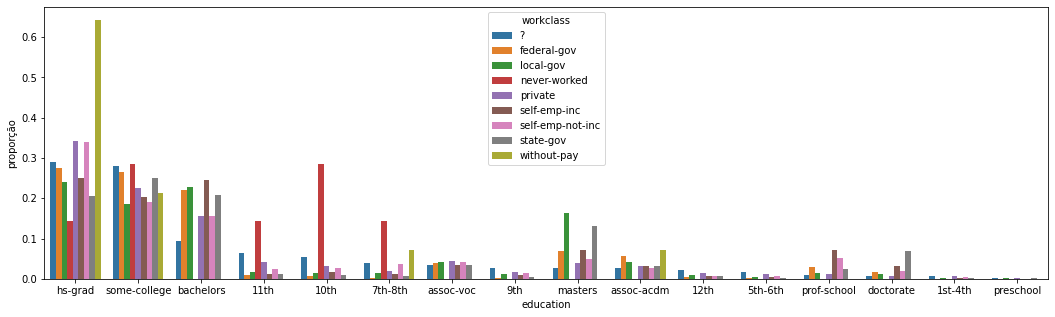

In [30]:
x, y, hue = "education", "proporção", "workclass"
plt.figure(figsize=(18,5))

(df_train[x]
 .groupby(df_train[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

<AxesSubplot:xlabel='relationship', ylabel='proporção'>

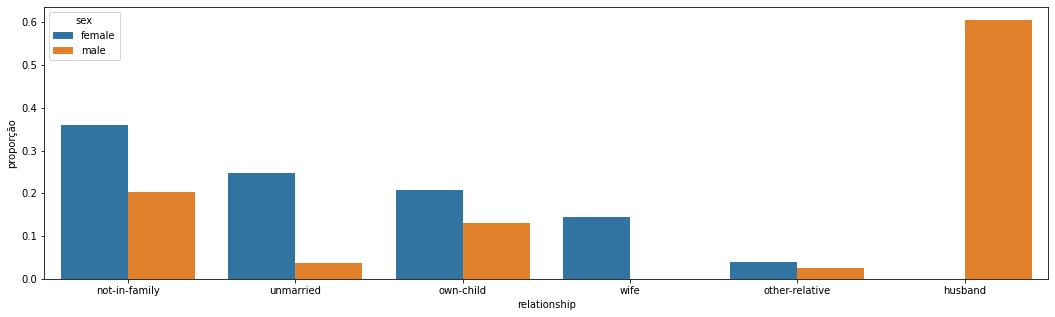

In [31]:
x, y, hue = "relationship", "proporção", "sex"
plt.figure(figsize=(18,5))

(df_train[x]
 .groupby(df_train[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

<AxesSubplot:xlabel='age'>

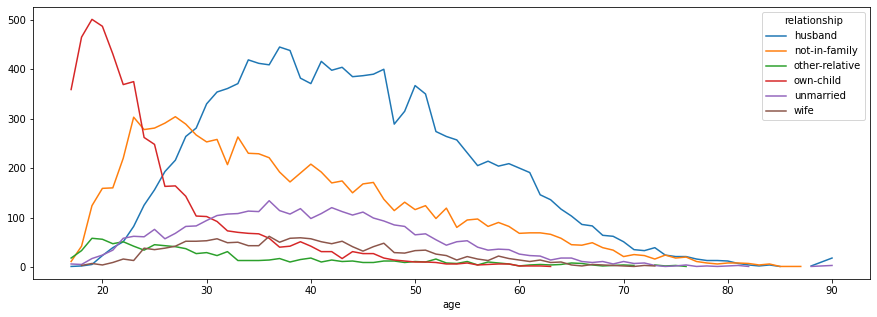

In [32]:
df_train.groupby(['age', 'relationship']).size().unstack().plot(kind='line', figsize=(15,5))

age                  AxesSubplot(0.125,0.657941;0.227941x0.222059)
fnlwgt            AxesSubplot(0.398529,0.657941;0.227941x0.222059)
education_num     AxesSubplot(0.672059,0.657941;0.227941x0.222059)
capital_gain         AxesSubplot(0.125,0.391471;0.227941x0.222059)
capital_loss      AxesSubplot(0.398529,0.391471;0.227941x0.222059)
hours_per_week    AxesSubplot(0.672059,0.391471;0.227941x0.222059)
dtype: object

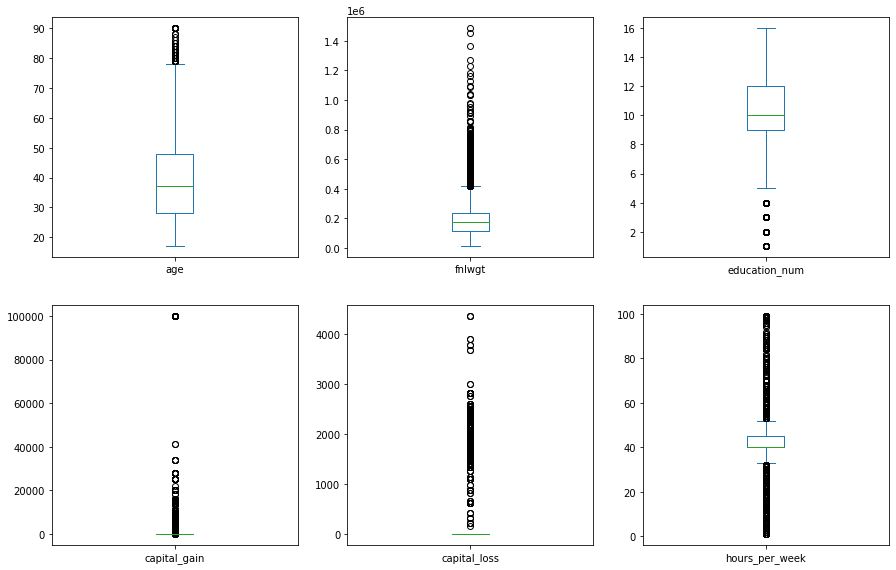

In [33]:
df_train[num_features].plot(kind='box', subplots= True, layout=(3,3), figsize=(15,15))

Essa boxplot nos permite verificar possíveis outliers (valores fora do comum) nos dados. As variáveis capital_gain e capital_loss, por exemplo, estão repletas de possíveis outliers, pois se observarmos são colunas esparsas.

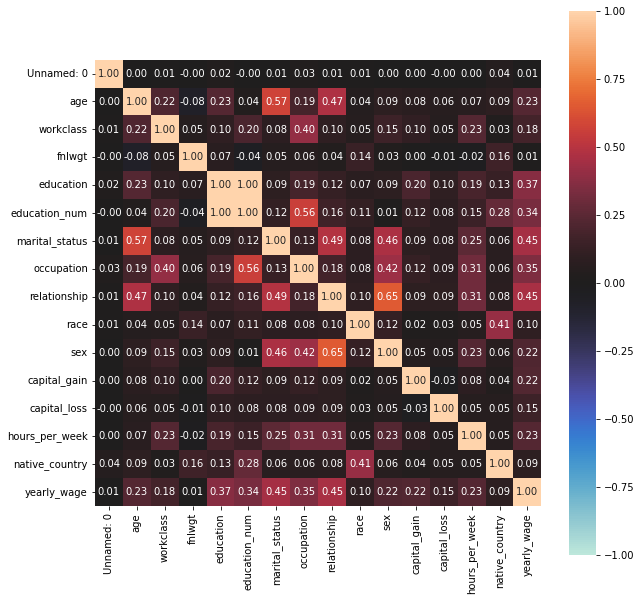

In [34]:
corr = associations(df_train, figsize=(10,10))
df_corr = corr['corr']

# Preparação dos dados

In [35]:
len(df_train.occupation.unique())

15

Quis apenas verificar se usaria ou não one hot encoding nessa coluna e chguei a conclusão que sim, pois ela não possui tantos valores distintos.

## Remoção de colunas que não usarei e remoção de valores nulos ("?")

In [36]:
cols_to_drop = ['Unnamed: 0', 'education', 'capital_gain', 'capital_loss', 'native_country']

In [37]:
df_train = df_train.drop(columns=cols_to_drop)
df_test = df_test.drop(columns=cols_to_drop)

In [38]:
df_train = df_train.replace(to_replace = '?', value = np.nan)
df_test = df_test.replace(to_replace = '?', value = np.nan)
df_train.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
hours_per_week       0
yearly_wage          0
dtype: int64

In [39]:
df_train.occupation.value_counts()

prof-specialty       4140
craft-repair         4099
exec-managerial      4066
adm-clerical         3769
sales                3650
other-service        3295
machine-op-inspct    2002
transport-moving     1597
handlers-cleaners    1370
farming-fishing       994
tech-support          928
protective-serv       649
priv-house-serv       149
armed-forces            9
Name: occupation, dtype: int64

Como apenas variáveis categóricas possuem valores nulos, vou substituí-los pelo valor da moda

In [40]:
null_columns = df_train.columns[df_train.isnull().any()]
for i in list(null_columns):
    df_train[i].fillna(df_train[i].mode().values[0],inplace=True)
    df_test[i].fillna(df_test[i].mode().values[0],inplace=True)

In [41]:
df_train.isna().sum()

age               0
workclass         0
fnlwgt            0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
hours_per_week    0
yearly_wage       0
dtype: int64

In [42]:
cat_features = set(cat_features) - set(cols_to_drop)
cat_features.remove('sex')
num_features = set(num_features) - set(cols_to_drop)
num_features

{'age', 'education_num', 'fnlwgt', 'hours_per_week'}

In [43]:
X_train = df_train.drop(columns=['yearly_wage'])
y = df_train.yearly_wage

## Encoding e normalização

In [44]:
X_train['sex'] = X_train['sex'].replace(['male', 'female'], [0, 1])
df_test['sex'] = df_test['sex'].replace(['male', 'female'], [0, 1])

In [45]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe_df = pd.DataFrame(ohe.fit_transform(X_train[cat_features]).toarray())
ohe_df_test = pd.DataFrame(ohe.transform(df_test[cat_features]).toarray())
X = X_train.join(ohe_df)
X_test = df_test.join(ohe_df_test)
X = X.drop(cat_features, axis=1)
X_test = X_test.drop(cat_features, axis=1)
X.head()

,age,fnlwgt,education_num,sex,hours_per_week,0,1,2,3,4,...,30,31,32,33,34,35,36,37,38,39
0,50,83311,13,0,13,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,38,215646,9,0,40,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,53,234721,7,0,40,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28,338409,13,1,40,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,37,284582,14,1,40,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
X_test.head()

,age,fnlwgt,education_num,sex,hours_per_week,0,1,2,3,4,...,30,31,32,33,34,35,36,37,38,39
0,38,89814,9,0,50,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,28,336951,12,0,40,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,44,160323,10,0,40,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18,103497,10,1,30,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,34,198693,6,0,30,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
min_max = MinMaxScaler()
X = min_max.fit_transform(X)
X_test = min_max.transform(X_test)

## Modelo

Escolhi o LGBM por ser um modelo extremamente rápido e com uma ótima acurácia, além disso ele se encaixa bem nesse caso, pois lida bem com dados desbalanceados por ter a otimização de gradiente e por ter atributos próprios no LGBMClassifier para isso (não os utilizei, pois não senti muita necessidade, afinal as variáveis que foram usadas não eram tão desbalanceadas).
Já na metrica, resolvi usar a acurácia por ser uma métrica que:
- 1 - Mostra como o modelo performou em geral.
- 2 - Esse projeto não é um projeto que me faça dar muita importância aos falsos positivos, como uma previsão de investimentos em ações, por exemplo. Se fosse, usaria a precisão ao invés da acurácia
- 3 - O projeto também não me faz dar muita importância aos falsos negativos, como um modelo de  previsão de doença. Se fizesse, usaria a métrica de recall.

In [48]:
search_spaces = [
    Integer(100, 2000, name='n_estimators'),
    Integer(20, 1000, name='num_leaves'),
    Integer(3, 10, name='max_depth'),
    Real(0.01, 0.5, 'log-uniform', name='learning_rate')
]

In [49]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=23)
scoring = 'accuracy'

In [50]:
'''@use_named_args(search_spaces)
def evalute_model(**params):
    model = LGBMClassifier()
    model.set_params(**params)
    print(params)
    
    result = -1*cross_val_score(model, X, y, cv=cv, scoring=scoring)
    print(result)
    
    return np.mean(result)'''

'@use_named_args(search_spaces)\ndef evalute_model(**params):\n    model = LGBMClassifier()\n    model.set_params(**params)\n    print(params)\n    \n    result = -1*cross_val_score(model, X, y, cv=cv, scoring=scoring)\n    print(result)\n    \n    return np.mean(result)'

In [51]:
#opt = gp_minimize(evalute_model, search_spaces, n_calls=30, verbose=1)

Deixei comentado, porque apesar do LGBM ser um dos modelos mais velozes, demoraria um pouco a achar os melhores parâmetros (que eu já encontrei e vou mostrar abaixo), mas sintam-se a vontade para descomentar e rodar tudo.

In [52]:
'''best_params = opt.x
best_params'''

'best_params = opt.x\nbest_params'

In [53]:
final_model = LGBMClassifier(n_estimators=1234, num_leaves=20, learning_rate=0.01, max_depth=6, verbose=0)

In [54]:
np.mean(cross_val_score(final_model, X, y, cv=cv, scoring=scoring))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warni

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM

0.8435401310401309

In [55]:
final_model.fit(X, y)
preds = final_model.predict(X_test)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [56]:
output = pd.DataFrame({'rowNumber': df_test.index,
                      'predictedValues': preds})
output.set_index('rowNumber', inplace=True)
output.to_csv('predicted.csv')